# Estudo da filtragem como técnica de pré processamento utilizando imagens de simulação do experimento CYGNO

<ol>
  <p>Desenvolvido por:</p>
    
    
  <li>Guilherme Sebastião Pinheiro Lopes, 
      
      e-mail: guilherme.lopes@engenharia.ufjf.br 
      
  </li>
  <li>Igor Abritta Costa,                 
    
      e-mail: igorabritta@gmail.com
  </li>
  <li>Rafael Antunes Nóbrega,             
    
      e-mail: ranobr@gmail.com
      
  </li>
</ol>

## Motivação deste trabalho

Na figura abaixo exibimos uma imagem que foi obtida através do detector ORANGE do experimento CYGNO. Nesta imagem é possível observar algumas caracteristicas importantes:

 <img src="images/motivation.png" />
 
 
     -Grande diferença de contraste nos elementos de interesse (Traços);
     -Presença de um ruído de fundo que pode mitigar informarções presente nos tracks.
     

A partir destes problemas nos questionamos se é possível desenvolver um conjunto de algoritmos capazes de nos retornar, de forma confiável, a informação correta sobre os traços vistos na imagem com o mínimo de informação de ruído possível.

Com o que temos hoje, essa pergunta só pode ser respondida de forma qualitativa, ou seja, aplicando diversas técnicas de processamento digital de imagens e ir avaliando qual delas nos traz um resultado visual melhor, porém será que conseguimos definir um número que consiga nos informar qual é a melhor técnica dentre as aplicadas? A resposta para hoje é não, visto que não sabemos quais pixels fazem parte do traço e quais não fazem. Então a melhor estratégia seria trabalhar em um ambiente parecido com o que estamos trabalhando de forma a desenvolver os algoritmos nesse ambiente e depois buscar técnicas para avaliação no ambiente real. A melhor estratégia para isso é trabalhar com imagens de simulação.

A colaboração CYGNO começou a desenvolver algoritmos utilizando softwares capazes de simular a interações físicas que ocorrem no interior do detector e transforma-las em imagens. Um exemplo é mostrado a abaixo:

In [3]:
## Importanto bibliotecas úteis
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
from scipy import signal
import h5py
import glob
import itertools
import pandas as pd
import seaborn as sns

In [2]:
folder = '../data/Runs001'
# lista com todos os arquivos dentro da pasta .h5
fullFiles  = glob.glob(folder + '/*.h5')
fullFiles

['../data/Runs001/first_simulations.h5']

(1300, 800)

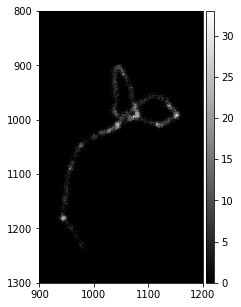

In [3]:
## Leitura dos arquivos
from mpl_toolkits.axes_grid1 import make_axes_locatable
f          = h5py.File(fullFiles[0],'r')
fig,ax = plt.subplots(1,1,figsize = (7,5))
divider = make_axes_locatable(ax)
im = ax.imshow(f['y_train'][0,:].reshape(2048,2048),cmap = 'gray')
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.set_xlim([900,1200])
ax.set_ylim([1300,800])

Munidos de uma imagem de simulação, fica bem claro onde encontramos os pixels que formam os tracks. Na escala de cinza, pode-se notar que o fundo da imagem apresenta valor zero e os pixels considerados traço estão acima desse valor, portanto podemos saber a localização destes pixels na imagem, como mostrado abaixo:

(1300, 800)

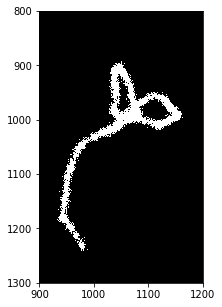

In [ ]:
## Leitura dos arquivos
from mpl_toolkits.axes_grid1 import make_axes_locatable
f          = h5py.File(fullFiles[0],'r')
fig,ax = plt.subplots(1,1,figsize = (7,5))
im = ax.imshow(f['y_train'][0,:].reshape(2048,2048)>0,cmap = 'gray')
ax.set_xlim([900,1200])
ax.set_ylim([1300,800])

Conhecendo a localização dos pixels, podemos desenvolver algoritmos que trabalhem para identificar quais pixels compoẽm o traço e quais pixels podem ser rejeitados. Como agora possuímos uma imagem "verdade" onde podemos recorrer, aplicaremos várias técnicas de forma a otimizar a eficiência de cada método comparando sempre com a imagem verdade.

Abaixo propomos um esquema de avaliação das técnicas utilizadas:


<img src="images/diagrama.png" />

1. Imagem de Simulação: Imagem geradas pela colaboração através do software garfield++ capazes de simular todas as interações físicas que ocorrem no interior do detector;

2. Ruído: Visualmente o ruído da imagem pode ser caracterizado por um valor de fundo constante (pedestal) somado a variações de intensidade dos pixels pertencentes á imagem em torno deste valor referência. As imagens de simulação não inserem o ruído eletrônico proveniente do sistema de leitura e portanto foi feito um estudo deste ruído de forma a criar uma simulação para adiciona-lo à imagem;

3. Pré-processamento: Com a imagem ruidosa, aplicaremos técnicas de pré-processamento (filtragem, redes neurais convolucionais..) para identificação dos pixels.

4. Clusterização: Após o pré-processamento, teremos vários clusters que formando a imagem e fica a cargo destes algoritmos identificar os pixels que fazem parte do mesmo cluster.

5. Eficiência: Com os clusters definidos podemos medir a eficência pelo numero de pixels que foram reconhecidos como traço e os pixels que realmente formam o traço, além disso, também podemos avaliar a esta mesma relação para pixels que não fazem parte do traço.

Com essas etapas bem definidas, entraremos no desenvolvimento de cada etapa exibindo a construção dos algoritmos e as conclusões a cerca de cada uma.



## Caracterização do ruído

Para caracterização do ruído, utilizamos bancos de dados gerados com o detector desligado, ou seja, sem enventos de interesse. Com isso, a única informação observada foi o ruído proveniente da eletrônica de leitura do detector.

Os bancos de dados cedidos pela colaboração para análise foram o Run817, Run818, Run819 e Run820 onde cada Run é composto por 100 imagens. A variável de mudança em cada Run é o tempo de obturação da câmera. 

<img src="images/run.png" />




Algumas técnicas para caracterização do ruído foram criadas utilizando características observadas nas imagens. A primeira consistiu em considerar a distribuição de intensidade de ruídos dos pixels e propor a geração dos pixels de ruído a partir da função densidade de probabilidade das intensidades dos pixels (paramétrica ou não). Isso não funcionou muito bem devido a observação de uma variação do ruído ao longo do tempo e de acordo com algumas condições no interior do detector. Portanto, a alternativa escolhida foi gerar os pixels baseados em sua distribuição de intensidades ao longo do tempo, de forma a melhorar a geração dos mesmos.

A ideia principal é que cada pixel tem sua própria distribuição de probabilidade e então, devemos definir quem são essas funções, seus parâmetros e o relacionamento entre essas funções (relacionamento entre pixels). Desta forma a caracterização do ruído pode ser segmentada nas seguintes etapas:

1. Entendimento dos runs
2. Identificação da distribuição dos pixels
3. Extração dos parâmetros das distribuições definidas
4. Verificação do relacionamento entre distribuições de pixels vizinhos

### Entendimento dos runs

In [4]:
## get images

def read_image_h5(file):
    # https://www.getdatajoy.com/learn/Read_and_Write_HDF5_from_Python#Reading_Data_from_HDF5_Files
    import numpy as np
    import h5py
    with h5py.File(file,'r') as hf:
        data = hf.get('Image')
        np_data = np.array(data)
    return np_data 

def get_noise_image(run,nTracks):
    tag = "%05d"
    shape     = (2048,2048) + (len(nTracks),)
    noiseData = np.zeros(shape)
    for i,trackNumber in list(enumerate(nTracks)):
         file        = '../../noise_database/Run'+str(run)+'/run' + str(run) + '-' + tag % trackNumber + '.h5'
         image       = read_image_h5(file)
         noiseData[:,:,i] = image
         #print('*')   
         #print("getting data from" + file)
         
    return noiseData     

In [5]:
noise = {}
pixels_statistics = {}
v_tracks = range(0,100) # lendo 50 primeiras imagens
runs = [817,818,819,820]
for run in runs:
    noise[str(run)] = get_noise_image(run,v_tracks)
    pixels_statistics['mean_'+str(run)] = (noise[str(run)].mean(axis=2)).ravel()
    pixels_statistics['std_'+str(run)] = (noise[str(run)].std(axis=2)).ravel()
pixels_statistics = pd.DataFrame.from_dict(pixels_statistics)    

MemoryError: 

Analisando a distribuição de cada pixel, podemos extrair parâmetros que podem nos ajudar no entendimento de suas características estatísticas. A primeira coisa que foi observado é se média e variância (ou desvio padrão) se mantinham constantes idenpendente do pixel e independente do Run. 

Extraimos as 50 primeiras amostras de cada pixel, e estimamos a média e variância dessas amostras. Como cada imagem possui 2048x2048 pixels, temos um número de amostras de média e std nesta ordem de grandeza.


O resultado pode ser exibido através de boxplots que facilitam a visualização destas grandezas. 

In [ ]:
plt.figure(figsize=(10,7))
pixels_statistics.boxplot(column=['mean_817','mean_818','mean_819','mean_820'])
plt.ylim([96,105])
plt.title('Distribuição das médias dos pixels')

In [ ]:
plt.figure(figsize=(10,7))
pixels_statistics.boxplot(column=['std_817','std_818','std_819','std_820'])
plt.ylim([0,5])
plt.title('Distribuição dos desvios padrões dos pixels')

Como podemos observar as distribuições variam de acordo com o run e também o número de outliers variam de acordo com o run( runs menores tendem a ter menos outliers). Isto pode ser visto melhor quando removemos o zoom dos plots

In [ ]:
plt.figure(figsize=(10,7))
pixels_statistics.boxplot(column=['mean_817','mean_818','mean_819','mean_820'])
#plt.ylim([96,105])
plt.title('Distribuição das médias dos pixels')

In [ ]:
plt.figure(figsize=(10,7))
pixels_statistics.boxplot(column=['std_817','std_818','std_819','std_820'])
#plt.ylim([0,5])
plt.title('Distribuição dos desvios padrões dos pixels')

A próxima pergunta que podemos fazer é se há alguma correlação entre a média das distribuição dos pixels e o desvio padrão destas mesmas distribuições. Essa pergunta pode ser respondida através dos scatters plots de cada run, mostrados nas figuras abaixo

In [ ]:
fig,ax = plt.subplots(2,2,figsize=(15,10))
ax = ax.ravel()
ax[0].scatter(pixels_statistics['mean_817'],pixels_statistics['std_817'], color = 'red',alpha = 0.3)
ax[0].grid()
ax[0].set_xlim([0,2500])
ax[0].set_ylim([0,100])
ax[0].set_title('Run 817')
ax[0].set_xlabel(r'$\mu$')
ax[0].set_ylabel(r'$\sigma$')

ax[1].scatter(pixels_statistics['mean_818'],pixels_statistics['std_818'], color = 'green',alpha = 0.3)
ax[1].grid()
ax[1].set_xlim([0,2500])
ax[1].set_ylim([0,100])
ax[1].set_title('Run 818')
ax[1].set_xlabel(r'$\mu$')
ax[1].set_ylabel(r'$\sigma$')

ax[2].scatter(pixels_statistics['mean_819'],pixels_statistics['std_819'], color = 'blue',alpha = 0.3)
ax[2].grid()
ax[2].set_xlim([0,2500])
ax[2].set_ylim([0,100])
ax[2].set_title('Run 819')
ax[2].set_xlabel(r'$\mu$')
ax[2].set_ylabel(r'$\sigma$')

ax[3].scatter(pixels_statistics['mean_820'],pixels_statistics['std_820'], color = 'yellow',alpha = 0.3)
ax[3].grid()
ax[3].set_xlim([0,2500])
ax[3].set_ylim([0,100])
ax[3].set_title('Run 820')
ax[3].set_xlabel(r'$\mu$')
ax[3].set_ylabel(r'$\sigma$')

Variando o run é possível observar o aparecimento de alguns grupos onde há correlação entre média e variância, principalmente nos runs com maiores níveis de ruído (820 por exemplo). Este comportamento pode ser aprofundado em um estudo completo sobre o ruído da eletrônica de leitura. Como nosso objetivo é apenas simular este ruído, nossa única preocupação é que o nosso ruído simulado apresente estas mesmas características

### Escolha de uma distribuição para simulação dos pixels de ruído

Agora nós iremos nos preocupar em determinar qual é a distribuição de cada pixel e se os pixels apresentam mesma distribuição (variando somente os parâmetros da mesma).

Primeiramente observamos os histogramas dessas distribuições para verificar se há similaridade com alguma distribuição conhecida.

In [ ]:
plt.hist(noise['817'][1,1,:],histtype = 'step',color = 'black',bins = 'scott')